<a href="https://colab.research.google.com/github/MSIMulti/AIFFEL_quest_cr/blob/master/MainQuest/Quest07/MainQuest07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요 라이브러리 로딩
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses, models
from sklearn.model_selection import train_test_split
from PIL import Image

print(tf.__version__)

2.17.1


In [ ]:
# Hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [ ]:
# 데이터 준비
DATASET_PATH = '/content/drive/MyDrive/AIFFEL/aiffel/main_quest_7'
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")  # "labels" 대신 "train_labels" 사용
if not os.listdir(img_dir):
    raise FileNotFoundError(f"No files found in train directory: {img_dir}")
x_train_filenames = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
if not os.listdir(label_dir):
    raise FileNotFoundError(f"No files found in train_labels directory: {label_dir}")
y_train_filenames = [os.path.join(label_dir, f) for f in os.listdir(label_dir)]
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2
)
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples:", num_train_examples)
print("Number of test examples:", num_test_examples)

Number of training examples: 240
Number of test examples: 60


In [ ]:
# 데이터 전처리 함수
def _process_pathnames(fname, label_path):
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.0
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [ ]:
# 데이터 증강 함수
def _augment(img, label_img):
    img = tf.image.random_flip_left_right(img)
    label_img = tf.image.random_flip_left_right(label_img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, label_img

In [ ]:
# tf.data.Dataset 구성
def get_dataset(filenames, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(filenames))
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = get_dataset(x_train_filenames, y_train_filenames)
test_dataset = get_dataset(x_test_filenames, y_test_filenames)

In [ ]:
# Encoder-Decoder 모델 정의
class EncoderDecoder(tf.keras.Model):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
        ])
        self.decoder = models.Sequential([
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, (1, 1), activation='sigmoid'),
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# U-Net 모델 정의
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(64)
        self.encoder2 = self.conv_block(128)
        self.encoder3 = self.conv_block(256)
        self.encoder4 = self.conv_block(512)

        self.center = self.conv_block(1024)

        self.decoder4 = self.deconv_block(512)
        self.decoder3 = self.deconv_block(256)
        self.decoder2 = self.deconv_block(128)
        self.decoder1 = self.deconv_block(64)

        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')

    def conv_block(self, filters):
        block = models.Sequential([
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        return block

    def deconv_block(self, filters):
        block = models.Sequential([
            layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        return block

    def call(self, inputs):
        enc1 = self.encoder1(inputs)
        enc2 = self.encoder2(layers.MaxPool2D((2, 2))(enc1))
        enc3 = self.encoder3(layers.MaxPool2D((2, 2))(enc2))
        enc4 = self.encoder4(layers.MaxPool2D((2, 2))(enc3))

        center = self.center(layers.MaxPool2D((2, 2))(enc4))

        dec4 = self.decoder4(tf.concat([center, tf.image.resize(enc4, center.shape[1:3])], axis=-1))
        dec3 = self.decoder3(tf.concat([dec4, tf.image.resize(enc3, dec4.shape[1:3])], axis=-1))
        dec2 = self.decoder2(tf.concat([dec3, tf.image.resize(enc2, dec3.shape[1:3])], axis=-1))
        dec1 = self.decoder1(tf.concat([dec2, tf.image.resize(enc1, dec2.shape[1:3])], axis=-1))

        outputs = self.output_conv(dec1)
        return outputs

In [ ]:
# Pretrained U-Net 모델 정의
class PretrainedUNet(tf.keras.Model):
    def __init__(self):
        super(PretrainedUNet, self).__init__()
        base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
        self.encoder_layers = [base_model.get_layer(name).output for name in [
            "block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3"
        ]]
        self.encoder = models.Model(inputs=base_model.input, outputs=self.encoder_layers)

        self.center = self.conv_block(1024)

        self.decoder4 = self.deconv_block(512)
        self.decoder3 = self.deconv_block(256)
        self.decoder2 = self.deconv_block(128)
        self.decoder1 = self.deconv_block(64)
        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')

    def conv_block(self, filters):
        return models.Sequential([
            layers.Conv2D(filters, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def deconv_block(self, filters):
        return models.Sequential([
            layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, inputs):
        enc1, enc2, enc3, enc4 = self.encoder(inputs)
        center = self.center(layers.MaxPool2D((2, 2))(enc4))

        # Resize to match the target shape for concatenation
        dec4 = self.decoder4(tf.concat([center, tf.image.resize(enc4, center.shape[1:3])], axis=-1))
        dec3 = self.decoder3(tf.concat([dec4, tf.image.resize(enc3, dec4.shape[1:3])], axis=-1))
        dec2 = self.decoder2(tf.concat([dec3, tf.image.resize(enc2, dec3.shape[1:3])], axis=-1))
        dec1 = self.decoder1(tf.concat([dec2, tf.image.resize(enc1, dec2.shape[1:3])], axis=-1))

        outputs = self.output_conv(dec1)
        return outputs

In [ ]:
# 모델 학습 및 성능 비교
models_to_train = {
    "Encoder-Decoder": EncoderDecoder(),
    "U-Net": UNet(),
    "Pretrained U-Net": PretrainedUNet(),
}

histories = {}
for model_name, model_instance in models_to_train.items():
    print(f"Training {model_name}...")
    model_instance.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss=losses.BinaryCrossentropy(),
                           metrics=['accuracy'])
    history = model_instance.fit(train_dataset,
                                  epochs=max_epochs,
                                  validation_data=test_dataset,
                                  callbacks=[
                                      tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(patience=3)
                                  ])
    histories[model_name] = history

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training Encoder-Decoder...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - accuracy: 0.9387 - loss: 0.3776 - val_accuracy: 0.9507 - val_loss: 0.1780
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9482 - loss: 0.1897 - val_accuracy: 0.9507 - val_loss: 0.1760
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9454 - loss: 0.1890 - val_accuracy: 0.9507 - val_loss: 0.1725
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9464 - loss: 0.1828 - val_accuracy: 0.9507 - val_loss: 0.1696
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9450 - loss: 0.1863 - val_accuracy: 0.9507 - val_loss: 0.1687
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9440 - loss: 0.1880 - val_accuracy: 0.9507 - val_loss: 0.1690
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9487 - loss: 0.1763 - val_accuracy: 0.9507 - val_loss: 0.1687
Epoch 8/10
30/30 ━━━━━━━━━━━━

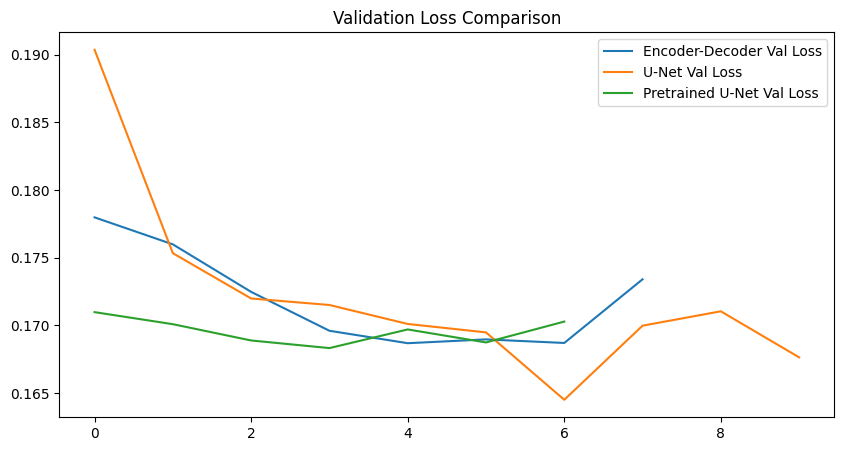

In [ ]:
# 성능 비교 시각화
def plot_comparison(histories):
    plt.figure(figsize=(10, 5))
    for model_name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f"{model_name} Val Loss")
    plt.legend()
    plt.title("Validation Loss Comparison")
    plt.show()

plot_comparison(histories)

Evaluating Encoder-Decoder...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


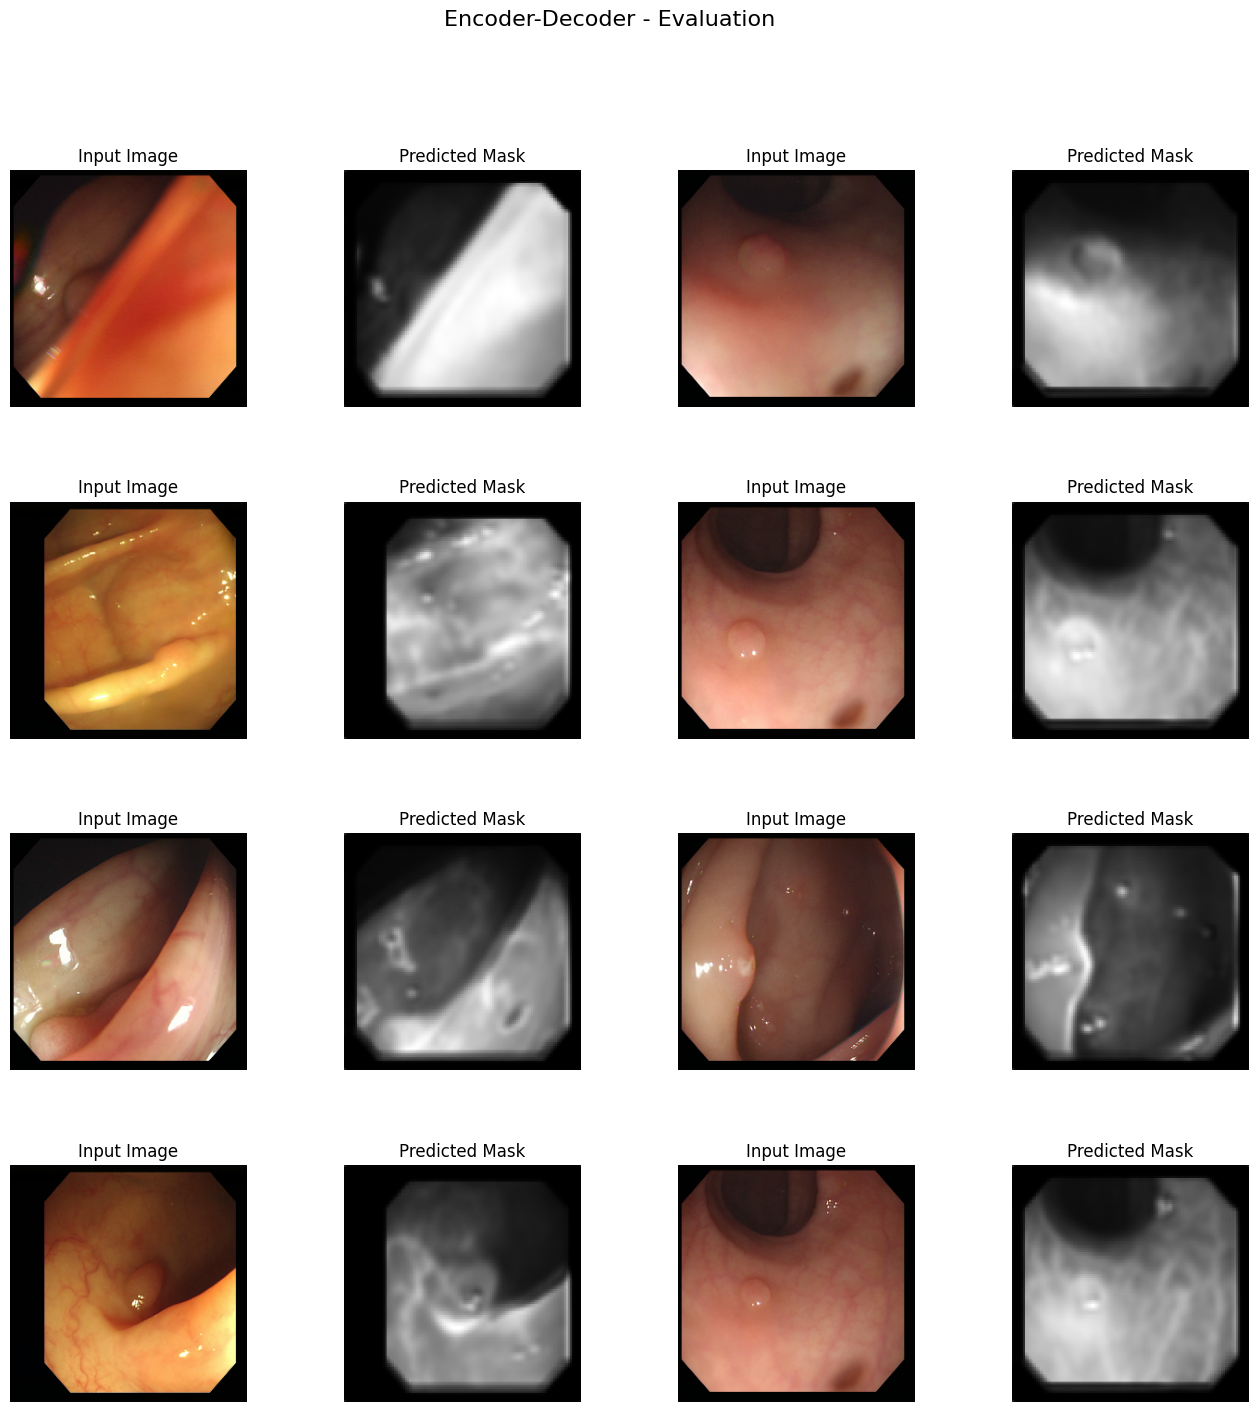

Evaluating U-Net...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


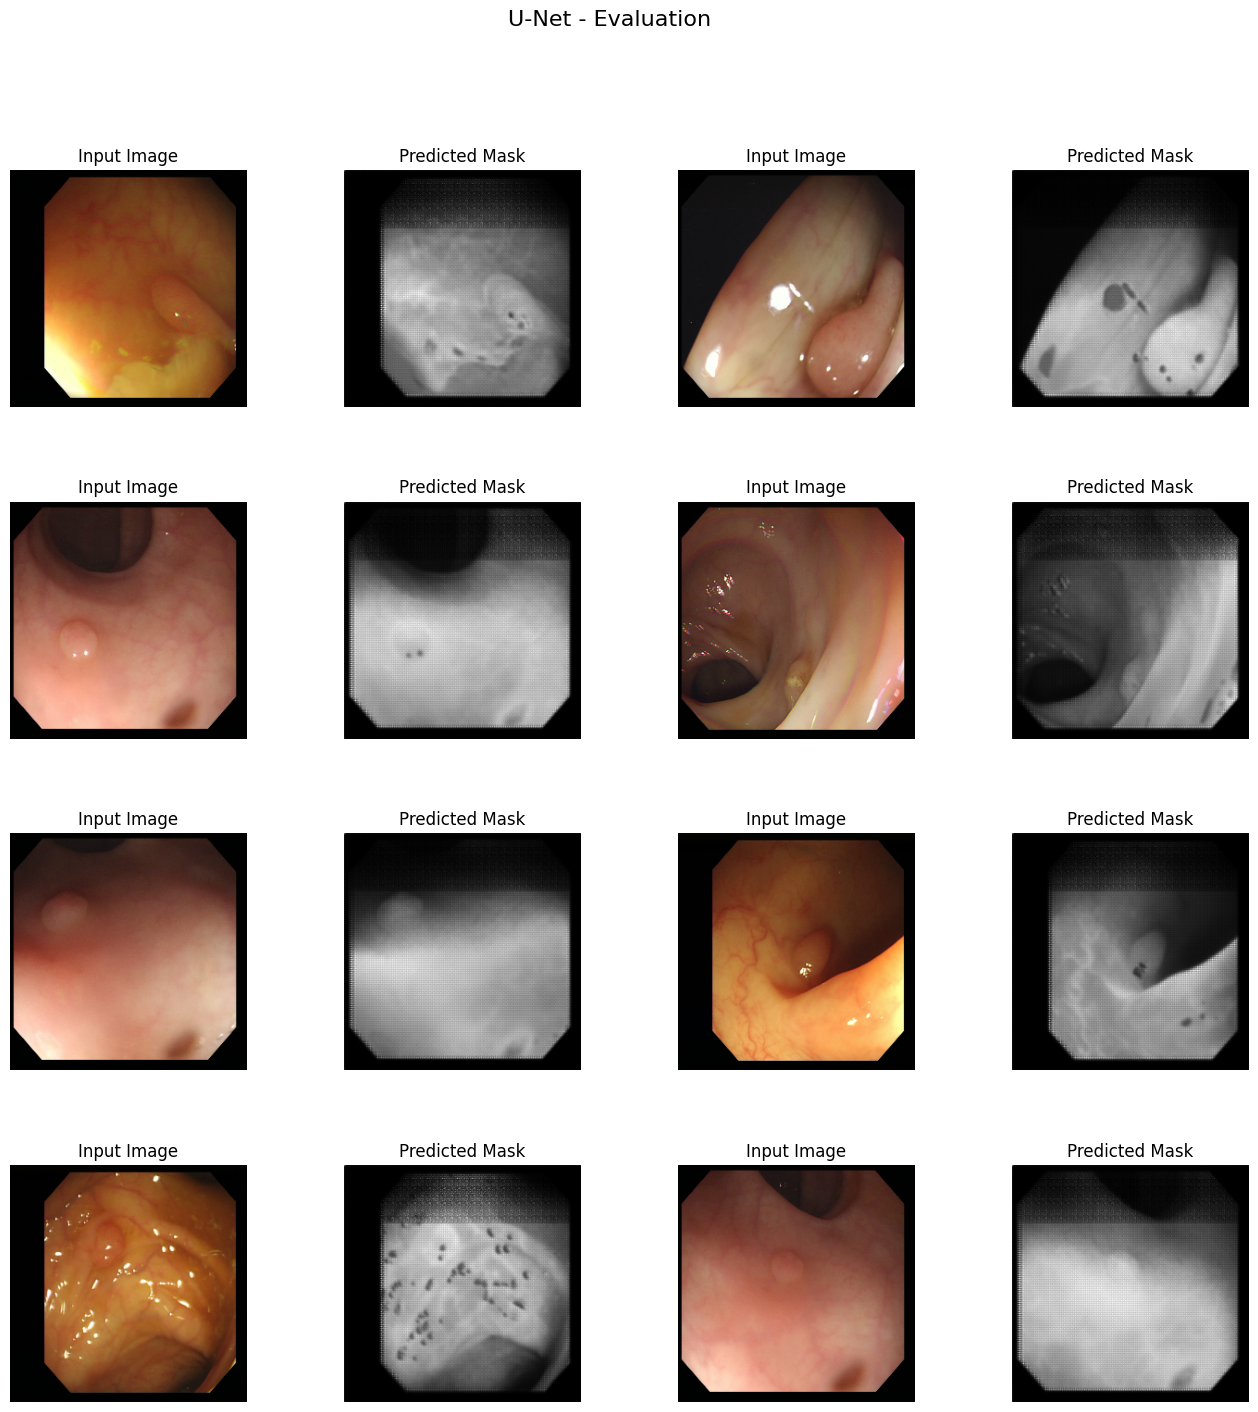

Evaluating Pretrained U-Net...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


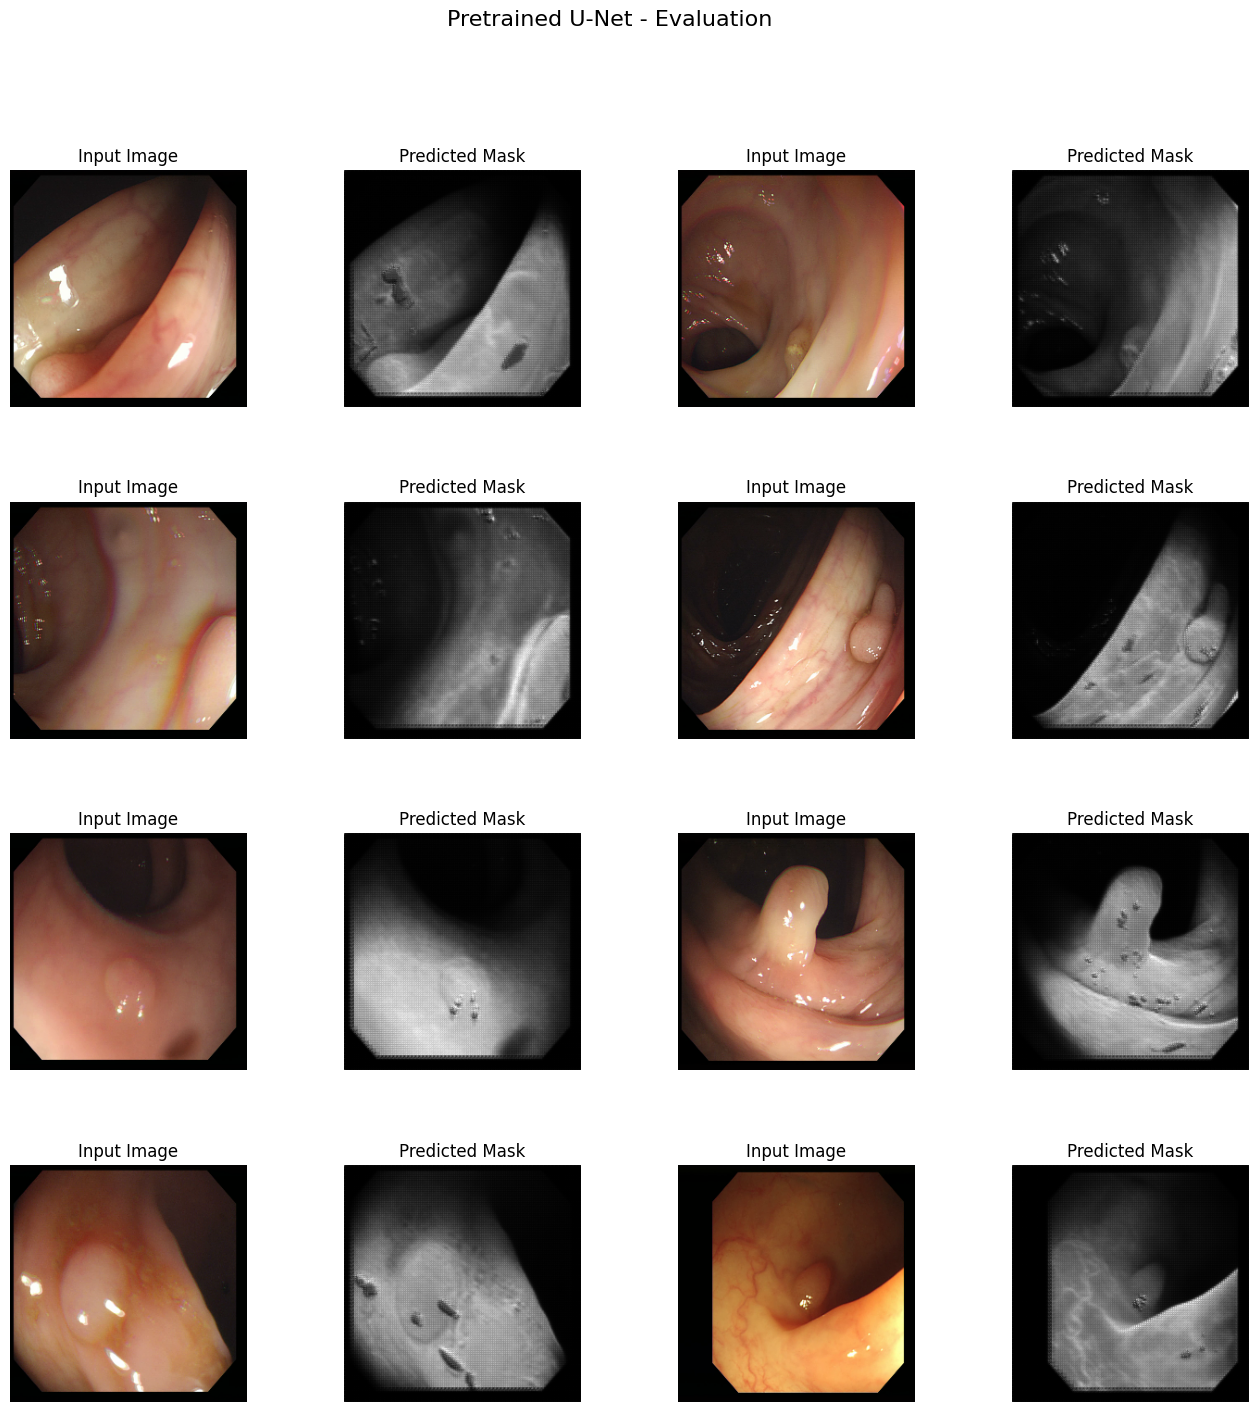

In [ ]:
# 모델 평가
def evaluate_all_models(models_to_train, test_dataset):
    for model_name, model_instance in models_to_train.items():
        print(f"Evaluating {model_name}...")
        for images, labels in test_dataset.take(1):  # 1개의 배치를 가져옵니다.
            predictions = model_instance.predict(images)  # 모델 예측

            # 결과 시각화
            fig, axes = plt.subplots(batch_size // 2, 4, figsize=(16, 16))
            axes = axes.flatten()
            fig.suptitle(f'{model_name} - Evaluation', fontsize=16)
            plt.subplots_adjust(wspace=0.4, hspace=0.4)  # 간격 조정

            for i in range(batch_size):
                axes[i * 2].imshow(images[i])
                axes[i * 2].set_title('Input Image')
                axes[i * 2].axis('off')

                axes[i * 2 + 1].imshow(predictions[i, :, :, 0], cmap='gray')
                axes[i * 2 + 1].set_title('Predicted Mask')
                axes[i * 2 + 1].axis('off')

            plt.show()

# 모델 학습 이후 평가 수행
evaluate_all_models(models_to_train, test_dataset)

# **회고**

# **모델 학습 결과 요약**
**Encoder-Decoder:**
- 빠른 학습 속도와 안정적인 수렴
- 세부적인 영역의 세그멘테이션 정확도가 부족
- 최종 Validation Loss: 0.1687

**U-Net:**
- 세부 영역 표현과 경계선 정확도가 가장 뛰어남
- 학습 시간이 상대적으로 느림
- 최종 Validation Loss: 0.1645 (가장 우수)

**Pretrained U-Net:**
- 초기 수렴이 빠르고 안정적이나, 작은 영역 표현에서 U-Net보다 약간 부족
- 학습 속도는 U-Net과 비슷
- 최종 Validation Loss: 0.1683

# **주요 시각화 결과**
**Validation Loss 비교:**
- 모든 모델이 안정적으로 수렴
- U-Net이 가장 낮은 Validation Loss를 기록
-

**Segmentation 결과:**
- U-Net: 가장 세부적인 표현과 정확한 경계선
- Encoder-Decoder: 경계선이 흐릿하고 작은 영역에서 부정확
- Pretrained U-Net: 안정적이지만 작은 영역 표현에서 약간 부족

# **결론**
- U-Net 모델이 가장 우수한 성능을 기록하며 의료 영상 세그멘테이션에 적합
- Pretrained U-Net은 초기 수렴이 빠르지만, U-Net 대비 세부 표현에서 약간 아쉬움
- 향후 개선을 통해 더욱 정교한 세그멘테이션 모델 구축 가능